# Recolorization
The purpose of the project is to add colors to a grayscale image, knowing the mean intensity of red, green and blue in the expected image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_datasets as tfds

We work on the oxford flower dataset

In [12]:
def load_flowers_dataset(num_samples=1000, img_size=128):
    ds = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
    ds = ds.map(lambda x: tf.image.resize(x['image'], (img_size, img_size)) / 255.0)
    ds = ds.take(num_samples).batch(num_samples)
    images = next(iter(ds)).numpy()
    return images

In [13]:
# === CONFIGURATION ===
IMG_SIZE = 128

Let us slightly reduce the resolution

In [14]:
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

Here is a simple generator. Feel free to adapt it to your needs. Preserve the logic and structure for the test phase.


In [15]:
# === DATA GENERATOR ===
class GrayScaleGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, shuffle=True):
        self.images = images.numpy() # Convert to numpy array
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_color = self.images[batch_indices]
        batch_gray = np.mean(batch_color,axis=-1)
        batch_palette = np.mean(batch_color,axis=(1,2)) # batch of color palettes
        return (batch_gray, batch_palette), batch_color

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [16]:
# === LOAD & SPLIT FLOWER DATA ===
def load_flower_dataset_splits():
    ds_train = tfds.load('oxford_flowers102', split='test', shuffle_files=True)
    ds_val = tfds.load('oxford_flowers102', split='validation', shuffle_files=True)
    ds_test = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
    ds_train = tf.stack(list(ds_train.map(preprocess_image)))
    ds_val = tf.stack(list(ds_val.map(preprocess_image)))
    ds_test = tf.stack(list(ds_test.map(preprocess_image)))
    return (ds_train,ds_val,ds_test)

In [17]:
train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()

train_gen = GrayScaleGenerator(train_imgs, batch_size=32)
val_gen = GrayScaleGenerator(val_imgs, batch_size=32)
test_gen = GrayScaleGenerator(test_imgs, batch_size=32)

We define a simple baseline, where we uniformly distribute colors according to the given input palette.

In [18]:
def baseline(gray,palette):
  m = np.mean(gray, axis=(1,2))
  red = gray*(palette[:,0]/m)[:, np.newaxis, np.newaxis]
  green = gray*(palette[:,1]/m)[:, np.newaxis, np.newaxis]
  blue = gray*(palette[:,2]/m)[:, np.newaxis, np.newaxis]
  return np.stack([red,green,blue],axis=-1)

Let us visualize a few examples.

In [19]:
# Sanity check
idx = np.random.randint(0, len(test_gen) - 1)
(x_gray,x_palette), y = test_gen[idx]
baseline_out = baseline(x_gray,x_palette)
print(x_gray.shape, x_palette.shape, y.shape)
print(baseline_out.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_gray[0],cmap='gray')
plt.title("GrayScale Image")

plt.subplot(1, 3, 2)
plt.imshow(y[0])
plt.title("Expected Out")

plt.subplot(1, 3, 3)
plt.imshow(baseline_out[0])
plt.title("Baseline")
plt.show()


(32, 128, 128) (32, 3) (32, 128, 128, 3)
(32, 128, 128, 3)


Your objective is to improve over the baseline.

Let us compute the error of the baseline on a batch of data.

In [10]:
idx = np.random.randint(0, len(test_gen) - 1)
(x_gray,x_palette), y = test_gen[idx]
baseline_out = baseline(x_gray,x_palette)
baseline_mse_batch = np.mean((baseline_out - y)**2,axis=(1,2))
baseline_mse = np.mean(baseline_mse_batch)
print(f"Baseline MSE: {baseline_mse:.4f}")

Baseline MSE: 0.0102


# Evaluation metric


The baseline error is already quite low. To better emphasize the correction we compute the ratio between the resulting error and the baseline one.
**This should be a value between 0 (perfect reconstruction) and 1 (no reconstruction). Higher values mean you are doing things worse.**

In [11]:
# Predict the repaired images
#replace mock_model with your model
def mock_model(xin):
  x_gray,x_palette = xin
  return baseline(x_gray,x_palette)

#generated_images = your_model.predict([x_gray, x_palette])
generated_images = mock_model([x_gray, x_palette])

# Compute the distance between generated image and original for the batch
generated_mes_batch = np.mean((generated_images - y)**2,axis=(1,2))
# Now let us compute the ratio, and the average over the batch
mean_ratio = np.mean(generated_mes_batch/baseline_mse_batch)

print(f"Average score (Generated / Initial): {mean_ratio:.4f}")

Average score (Generated / Initial): 1.0000


In the previous case, since we used baseline as model, we get a score of 1.

**Repeat the previous computation for all batches in testing data, and return mean and standard deviation.**

# Parameters

Try to keep below 5M parameters (total, excluding parameteres of the optimizer).

You have the usual constraints:
* the project should be written in keras
* you should submit a single well documented notebook
* try to give access to weights through gdown




# Import Libraries

In [6]:
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model, Input
import matplotlib.pyplot as plt

In [7]:
IMG_SIZE   = 128
BATCH_SIZE = 32

tf.get_logger().setLevel('ERROR')

# Dataset

Generating dataset in Tensorflow format

In [39]:
def make_ds(images, batch_size, training):
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    images.set_shape([None, IMG_SIZE, IMG_SIZE, 3])  # (N,H,W,3)

    def _map(img):
        img.set_shape([IMG_SIZE, IMG_SIZE, 3])                 # per-example
        gray = tf.reduce_mean(img, axis=-1, keepdims=True)     # (H,W,1)
        gray.set_shape([IMG_SIZE, IMG_SIZE, 1])

        pal  = tf.reduce_mean(img, axis=(0,1))                 # (3,)
        pal.set_shape([3])

        return (gray, pal), img

    ds = tf.data.Dataset.from_tensor_slices(images)
    if training:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


The baseline function rewrite compatible with tensorflow
necessary for showing GenMSE/BaselineMSE Ratio and STD

In [40]:
@tf.function
def baseline_tf(gray, palette):
    """
    gray:    (B,H,W) or (B,H,W,1)
    palette: (B,3)  (will be forced to B from gray)
    return:  (B,H,W,3)
    """
    # Coerce gray to 4D (B,H,W,1) without data-dependent control flow
    s = tf.shape(gray)                               # rank 3 or 4
    gray = tf.reshape(gray, tf.concat([s[:3], [1]], axis=0))  # (B,H,W,1)
    s4 = tf.shape(gray)
    B, H, W = s4[0], s4[1], s4[2]

    # Force palette to (B,3) using B from gray
    palette = tf.reshape(palette, tf.stack([B, 3]))  # (B,3)

    # Build palette map explicitly (no broadcasting surprises)
    pal = palette[:, tf.newaxis, tf.newaxis, :]      # (B,1,1,3)
    pal = tf.repeat(pal, H, axis=1)                  # (B,H,1,3)
    pal = tf.repeat(pal, W, axis=2)                  # (B,H,W,3)

    # Mean gray per image, expanded to (B,H,W,1)
    g2d = tf.squeeze(gray, axis=-1)                  # (B,H,W)
    m   = tf.reduce_mean(g2d, axis=(1,2), keepdims=True) + 1e-8   # (B,1,1)
    m   = tf.repeat(m, H, axis=1)                                    # (B,H,1)
    m   = tf.repeat(m, W, axis=2)[..., tf.newaxis]                    # (B,H,W,1)

    return tf.clip_by_value(g2d[..., tf.newaxis] * (pal / m), 0.0, 1.0)  # (B,H,W,3)


Create Train/Val/Test Datasets

In [41]:
train_ds = make_ds(train_imgs, BATCH_SIZE, training=True)
val_ds   = make_ds(val_imgs,   BATCH_SIZE, training=False)
test_ds  = make_ds(test_imgs,  BATCH_SIZE, training=False)


Showing an example for test dataset and baseline function

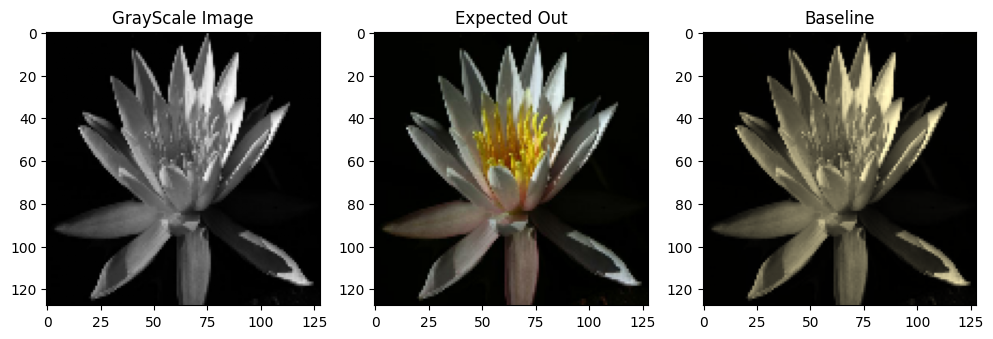

In [52]:
# Sanity check
idx = np.random.randint(0, len(list(test_ds)) - 1)
(x_gray,x_palette), y = list(test_ds)[idx]
baseline_out = baseline_tf(x_gray,x_palette)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_gray[0],cmap='gray')
plt.title("GrayScale Image")

plt.subplot(1, 3, 2)
plt.imshow(y[0])
plt.title("Expected Out")

plt.subplot(1, 3, 3)
plt.imshow(baseline_out[0])
plt.title("Baseline")
plt.show()


# Model

building colorizer model
using UNet architecture

we have a widths input to generate model in different sizes easily

In [3]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    return x

def down_block(x, filters):
    c = conv_block(x, filters); p = layers.MaxPooling2D()(c); return c, p

def up_block(x, skip, filters):
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_colorizer(img_size=128, widths=(32, 64, 128, 256), bottleneck=256):
    """
    widths: channels for the 4 encoder stages
    bottleneck: channels at the bottom
    Default config is comfortably < 5M params.
    """
    x_gray    = Input(shape=(img_size, img_size, 1), name='gray')
    x_palette = Input(shape=(3,), name='palette')

    # Robust palette tiling
    pal_map = layers.Lambda(
        lambda p: tf.tile(tf.reshape(p, (-1, 1, 1, 3)), [1, img_size, img_size, 1]),
        name="palette_tiled"
    )(x_palette)

    x = layers.Concatenate(name="concat_gray_palette")([x_gray, pal_map])  # (B,H,W,4)

    # Encoder
    c1, p1 = down_block(x,        widths[0])
    c2, p2 = down_block(p1,       widths[1])
    c3, p3 = down_block(p2,       widths[2])
    c4, p4 = down_block(p3,       widths[3])

    # Bottleneck
    bn = conv_block(p4, bottleneck)

    # Decoder
    u1 = up_block(bn, c4, widths[3])
    u2 = up_block(u1, c3, widths[2])
    u3 = up_block(u2, c2, widths[1])
    u4 = up_block(u3, c1, widths[0])

    out = layers.Conv2D(3, 1, activation='sigmoid', name='rgb')(u4)
    return Model(inputs=[x_gray, x_palette], outputs=out, name='PaletteUNet_Lite')


Generating the model and showing summery

The model has less than 5 Million parameters

In [76]:
core = build_colorizer(img_size=IMG_SIZE, widths=(32,64,128,256), bottleneck=256)

core.summary(line_length=120)
total_params = core.count_params()
print(f"\nTotal trainable parameters (core): {total_params:,}")


Model: "PaletteUNet_Lite"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ palette (InputLayer)              │ (None, 3)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ gray (InputLayer)                 │ (None, 128, 128, 1)          │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ palette_tiled (Lambda)            │ (None, 128, 128, 3)          │                 0 │ palette[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ concat_gray_palette (Concatenate) │ (None, 128, 128, 4)          │                 0 │ gray[0][0],               
│                                   │                              │                   │ palette_tiled[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_54 (Conv2D)                │ (None, 128, 128, 32)         │             1,184 │ concat_gray_palette[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_54            │ (None, 128, 128, 32)         │               128 │ conv2d_54[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_54 (Activation)        │ (None, 128, 128, 32)         │                 0 │ batch_normalization_54[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_55 (Conv2D)                │ (None, 128, 128, 32)         │             9,248 │ activation_54[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_55            │ (None, 128, 128, 32)         │               128 │ conv2d_55[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_55 (Activation)        │ (None, 128, 128, 32)         │                 0 │ batch_normalization_55[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d_12 (MaxPooling2D)   │ (None, 64, 64, 32)           │                 0 │ activation_55[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_56 (Conv2D)                │ (None, 64, 64, 64)           │            18,496 │ max_pooling2d_12[0][0]    
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_56            │ (None, 64, 64, 64)           │               256 │ conv2d_56[0][0]           
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ activation_56 (Activation)        │ (None, 64, 64, 64)           │                 0 │ batch_normalization_56[0][
├───────────────────────────────────┼───────────────────

 Total params: 4,907,107 (18.72 MB)

 Trainable params: 4,902,243 (18.70 MB)

 Non-trainable params: 4,864 (19.00 KB)


Total trainable parameters (core): 4,907,107


# Helpers

## Live Metrics

Define live metrics to tracking mse, GeneratedMse/BaselineMse Ration and Std, live in training and test

In [74]:
class RunningStd(tf.keras.metrics.Metric):
    """Population std over all per-image values seen in the epoch (graph-safe)."""
    def __init__(self, name='ratio_std', **kwargs):
        super().__init__(name=name, **kwargs)
        self.n    = self.add_weight(name='count', shape=(), initializer='zeros', dtype=tf.float32)
        self.mean = self.add_weight(name='mean',  shape=(), initializer='zeros', dtype=tf.float32)
        self.M2   = self.add_weight(name='m2',    shape=(), initializer='zeros', dtype=tf.float32)

    def update_state(self, values):
        # Flatten to 1D float32
        x  = tf.reshape(tf.cast(values, tf.float32), [-1])
        nb = tf.cast(tf.size(x), tf.float32)                 # batch count (scalar)

        # Batch mean/M2 computed with divide_no_nan (safe when nb == 0)
        b_mean = tf.math.divide_no_nan(tf.reduce_sum(x), nb) # scalar
        b_M2   = tf.reduce_sum(tf.square(x - b_mean))        # scalar

        n_a, mean_a, M2_a = self.n, self.mean, self.M2       # running stats so far
        n_total = n_a + nb                                    # scalar

        # Chan’s merge, guarded with tf.where (no Python ifs)
        delta     = b_mean - mean_a                           # scalar
        mean_new  = tf.where(nb > 0.0, mean_a + delta * (nb / tf.maximum(n_total, 1e-12)), mean_a)
        M2_new    = tf.where(
            nb > 0.0,
            M2_a + b_M2 + tf.square(delta) * (n_a * nb / tf.maximum(n_total, 1e-12)),
            M2_a
        )
        n_new = n_total  # adding 0 is fine if nb==0

        self.n.assign(n_new)
        self.mean.assign(mean_new)
        self.M2.assign(M2_new)

    def result(self):
        # Population std = sqrt(M2 / n); safe when n==0
        return tf.sqrt(tf.math.divide_no_nan(self.M2, self.n))

    def reset_state(self):
        self.n.assign(0.0)
        self.mean.assign(0.0)
        self.M2.assign(0.0)


In [75]:
@tf.function
def batch_mse(a, b):
    return tf.reduce_mean(tf.square(a - b), axis=(1,2,3))

## Loss

We use ssim and mse combined loss

In [56]:
def ssim_loss(y_true, y_pred):
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return 1.0 - tf.reduce_mean(ssim)

def combined_loss(y_true, y_pred):
    mse  = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.5*mse + 0.5*ssim_loss(y_true, y_pred)

# Model Wrapper

We define a wrapper to update metrics live during training
Also implementing train and test step

In [69]:
class ColorizerWrapper(tf.keras.Model):
    def __init__(self, core_model):
        super().__init__()
        self.core = core_model
        self.mse_metric   = tf.keras.metrics.MeanSquaredError(name='mse')
        self.ratio_metric = tf.keras.metrics.Mean(name='ratio')   # mean of ratios
        self.ratio_std    = RunningStd(name='ratio_std')          # std of ratios

    def call(self, inputs, training=False):
        return self.core(inputs, training=training)

    @property
    def metrics(self):
        return [self.mse_metric, self.ratio_metric, self.ratio_std]

    def _update_ratio_metrics(self, xg, y, y_pred):
        xp = tf.reduce_mean(y, axis=(1, 2))                 # (B,3)
        base     = baseline_tf(xg, xp)
        gen_mse  = batch_mse(y_pred, y)                     # (B,)
        base_mse = batch_mse(base, y) + 1e-12               # (B,)
        ratios   = gen_mse / base_mse                       # (B,)
        self.ratio_metric.update_state(tf.reduce_mean(ratios))
        self.ratio_std.update_state(ratios)

    def train_step(self, data):
        (xg, _), y = data
        xp = tf.reduce_mean(y, axis=(1, 2))

        with tf.GradientTape() as tape:
            y_pred = self.core([xg, xp], training=True)     # predict RGB
            loss = combined_loss(y, y_pred)                 # explicit scalar loss
            reg_losses = self.core.losses
            if reg_losses:
                loss += tf.add_n(reg_losses)

        vars_ = self.core.trainable_variables
        grads = tape.gradient(loss, vars_)

        self.optimizer.apply_gradients(zip(grads, vars_))

        # metrics
        self.mse_metric.update_state(y, y_pred)
        self._update_ratio_metrics(xg, y, y_pred)

        return {
            'loss':      tf.cast(loss, tf.float32),
            'mse':       tf.cast(self.mse_metric.result(), tf.float32),
            'ratio':     tf.cast(self.ratio_metric.result(), tf.float32),
            'ratio_std': tf.cast(self.ratio_std.result(), tf.float32),
        }

    def test_step(self, data):
        (xg, _), y = data
        xp = tf.reduce_mean(y, axis=(1, 2))

        y_pred = self.core([xg, xp], training=False)
        loss = combined_loss(y, y_pred)
        reg_losses = self.core.losses
        if reg_losses:
            loss += tf.add_n(reg_losses)

        self.mse_metric.update_state(y, y_pred)
        self._update_ratio_metrics(xg, y, y_pred)

        return {
            'loss':      tf.cast(loss, tf.float32),
            'mse':       tf.cast(self.mse_metric.result(), tf.float32),
            'ratio':     tf.cast(self.ratio_metric.result(), tf.float32),
            'ratio_std': tf.cast(self.ratio_std.result(), tf.float32),
        }


# Training

In [18]:
wrapper = ColorizerWrapper(core)

wrapper.compile(
    optimizer=tf.keras.optimizers.Adam(5e-3),
    loss=combined_loss,
    run_eagerly=False
)


callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=8, restore_best_weights=True, verbose=1, mode='min'),
    tf.keras.callbacks.ModelCheckpoint('best_colorizer.h5', monitor='val_mse', save_best_only=True, verbose=1)
]

history = wrapper.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=100,
    verbose=1
)

results = wrapper.evaluate(test_ds, return_dict=True)
print(f"Test mean_ratio: {results['ratio']:.4f} | std_ratio: {results['ratio_std']:.4f}")

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0780 - mse: 0.0119 - ratio: 1.7228 - ratio_std: 2.6999
Epoch 1: val_mse did not improve from 0.00548
192/192 ━━━━━━━━━━━━━━━━━━━━ 61s 199ms/step - loss: 0.0779 - mse: 0.0119 - ratio: 1.7205 - ratio_std: 2.6950 - val_loss: 0.2906 - val_mse: 0.1016 - val_ratio: 26.7062 - val_ratio_std: 58.4541 - learning_rate: 0.0050
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0689 - mse: 0.0078 - ratio: 0.9763 - ratio_std: 0.6958
Epoch 2: val_mse did not improve from 0.00548
192/192 ━━━━━━━━━━━━━━━━━━━━ 68s 177ms/step - loss: 0.0689 - mse: 0.0078 - ratio: 0.9763 - ratio_std: 0.6958 - val_loss: 0.1176 - val_mse: 0.0164 - val_ratio: 2.7047 - val_ratio_std: 2.7395 - learning_rate: 0.0050
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0670 - mse: 0.0074 - ratio: 0.9416 - ratio_std: 0.6635
Epoch 3: val_mse did not improve from 0.00548
192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - loss: 0.0671 - mse: 0.0074

192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - loss: 0.0537 - mse: 0.0053 - ratio: 0.7250 - ratio_std: 0.5526 - val_loss: 0.0640 - val_mse: 0.0053 - val_ratio: 0.6762 - val_ratio_std: 0.4159 - learning_rate: 0.0025
Epoch 20/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0534 - mse: 0.0054 - ratio: 0.7049 - ratio_std: 0.5225
Epoch 20: val_mse did not improve from 0.00534
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 0.0534 - mse: 0.0054 - ratio: 0.7049 - ratio_std: 0.5225 - val_loss: 0.0620 - val_mse: 0.0065 - val_ratio: 0.9413 - val_ratio_std: 1.8741 - learning_rate: 0.0025
Epoch 21/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0533 - mse: 0.0052 - ratio: 0.6844 - ratio_std: 0.4511
Epoch 21: val_mse did not improve from 0.00534
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 0.0533 - mse: 0.0052 - ratio: 0.6844 - ratio_std: 0.4511 - val_loss: 0.0834 - val_mse: 0.0190 - val_ratio: 3.4958 - val_ratio_std: 11.8261 - learning_rate: 0.0025
Epoch 22/100
192/192 

192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 183ms/step - loss: 0.0509 - mse: 0.0050 - ratio: 0.6616 - ratio_std: 0.4564 - val_loss: 0.0598 - val_mse: 0.0051 - val_ratio: 0.6337 - val_ratio_std: 0.3677 - learning_rate: 0.0012
Epoch 24/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0497 - mse: 0.0046 - ratio: 0.6220 - ratio_std: 0.4053
Epoch 24: val_mse improved from 0.00512 to 0.00492, saving model to best_colorizer.h5


192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - loss: 0.0496 - mse: 0.0046 - ratio: 0.6220 - ratio_std: 0.4054 - val_loss: 0.0596 - val_mse: 0.0049 - val_ratio: 0.6491 - val_ratio_std: 0.4292 - learning_rate: 0.0012
Epoch 25/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0491 - mse: 0.0045 - ratio: 0.6078 - ratio_std: 0.4045
Epoch 25: val_mse did not improve from 0.00492
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 0.0491 - mse: 0.0045 - ratio: 0.6078 - ratio_std: 0.4045 - val_loss: 0.0603 - val_mse: 0.0051 - val_ratio: 0.6233 - val_ratio_std: 0.3305 - learning_rate: 0.0012
Epoch 26/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0485 - mse: 0.0044 - ratio: 0.5984 - ratio_std: 0.3933
Epoch 26: val_mse did not improve from 0.00492
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 0.0485 - mse: 0.0044 - ratio: 0.5984 - ratio_std: 0.3934 - val_loss: 0.0608 - val_mse: 0.0050 - val_ratio: 0.6247 - val_ratio_std: 0.3575 - learning_rate: 0.0012
Epoch 27/100
192/192 ━

192/192 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - loss: 0.0464 - mse: 0.0042 - ratio: 0.5772 - ratio_std: 0.3899 - val_loss: 0.0602 - val_mse: 0.0048 - val_ratio: 0.5877 - val_ratio_std: 0.3093 - learning_rate: 6.2500e-04
Epoch 29/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0459 - mse: 0.0041 - ratio: 0.5542 - ratio_std: 0.3852
Epoch 29: val_mse did not improve from 0.00484
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 0.0459 - mse: 0.0041 - ratio: 0.5542 - ratio_std: 0.3852 - val_loss: 0.0601 - val_mse: 0.0050 - val_ratio: 0.6305 - val_ratio_std: 0.4508 - learning_rate: 6.2500e-04
Epoch 30/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0457 - mse: 0.0041 - ratio: 0.5587 - ratio_std: 0.4198
Epoch 30: val_mse improved from 0.00484 to 0.00480, saving model to best_colorizer.h5


192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 178ms/step - loss: 0.0456 - mse: 0.0041 - ratio: 0.5587 - ratio_std: 0.4198 - val_loss: 0.0579 - val_mse: 0.0048 - val_ratio: 0.6076 - val_ratio_std: 0.3747 - learning_rate: 6.2500e-04
Epoch 31/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0452 - mse: 0.0041 - ratio: 0.5587 - ratio_std: 0.4320
Epoch 31: val_mse did not improve from 0.00480
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 0.0452 - mse: 0.0041 - ratio: 0.5586 - ratio_std: 0.4320 - val_loss: 0.0586 - val_mse: 0.0051 - val_ratio: 0.6702 - val_ratio_std: 0.5019 - learning_rate: 6.2500e-04
Epoch 32/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0451 - mse: 0.0040 - ratio: 0.5619 - ratio_std: 0.4268
Epoch 32: val_mse improved from 0.00480 to 0.00476, saving model to best_colorizer.h5


192/192 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - loss: 0.0450 - mse: 0.0040 - ratio: 0.5619 - ratio_std: 0.4269 - val_loss: 0.0572 - val_mse: 0.0048 - val_ratio: 0.5974 - val_ratio_std: 0.3563 - learning_rate: 6.2500e-04
Epoch 33/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0445 - mse: 0.0039 - ratio: 0.5332 - ratio_std: 0.3702
Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 33: val_mse did not improve from 0.00476
192/192 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 0.0445 - mse: 0.0039 - ratio: 0.5333 - ratio_std: 0.3704 - val_loss: 0.0610 - val_mse: 0.0052 - val_ratio: 0.6644 - val_ratio_std: 0.4691 - learning_rate: 6.2500e-04
Epoch 34/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0435 - mse: 0.0038 - ratio: 0.5372 - ratio_std: 0.4021
Epoch 34: val_mse did not improve from 0.00476
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - loss: 0.0434 - mse: 0.0038 - ratio: 0.5372 - ratio_std: 0.4021 - val_loss: 0.0580 - val_mse: 0.0048 - va

# Save Model

In [ ]:
# wrapper.core.save_weights('colorizer_model_2.weights.h5')
# print("Model weights saved to colorizer_model_2.weights.h5")

# Model Output


## Plot Examples

In [4]:
def show_test_examples(model_or_wrapper, test_gen, n=15):
    """
    Show n examples from the first batch of test_gen:
    Gray, Palette, Baseline, Model, Ground truth
    Also overlays the per-image ratio (MSE(model)/MSE(baseline)).
    """
    # fetch one batch
    (xg, _), y = test_gen[0]                       # xg: (B,H,W,1) or (B,H,W), y: (B,H,W,3)

    # tensors
    xg_tf = tf.convert_to_tensor(xg, tf.float32)
    # ensure gray has channel dim
    if xg_tf.shape.rank == 3:
        xg_tf = xg_tf[..., tf.newaxis]             # (B,H,W,1)
    y_tf  = tf.convert_to_tensor(y,  tf.float32)

    # palette from GT (robust)
    xp_tf = tf.reduce_mean(y_tf, axis=(1, 2))      # (B,3)

    # forward pass (works for wrapper or core)
    model = model_or_wrapper.core if hasattr(model_or_wrapper, "core") else model_or_wrapper
    y_pred = model([xg_tf, xp_tf], training=False).numpy()

    # baseline
    base = baseline_tf(xg_tf, xp_tf).numpy()

    # per-image ratios
    gen_mse  = np.mean((y_pred - y)**2, axis=(1,2,3))
    base_mse = np.mean((base   - y)**2, axis=(1,2,3)) + 1e-12
    ratios   = gen_mse / base_mse

    # visuals
    gray_imgs = np.squeeze(xg_tf.numpy(), axis=-1)  # (B,H,W)
    n = min(n, gray_imgs.shape[0])
    cols = 5
    plt.figure(figsize=(cols * 3.2, n * 3.2))
    for i in range(n):
        # Gray
        plt.subplot(n, cols, i*cols + 1)
        plt.imshow(gray_imgs[i], cmap='gray'); plt.axis('off'); plt.title('Gray')

        # Palette strip
        plt.subplot(n, cols, i*cols + 2)
        pal_strip = np.ones((20, 120, 3), dtype=np.float32) * xp_tf[i].numpy()
        plt.imshow(pal_strip); plt.axis('off'); plt.title('Palette')

        # Baseline
        plt.subplot(n, cols, i*cols + 3)
        plt.imshow(base[i]); plt.axis('off'); plt.title('Baseline')

        # Model (+ ratio in title)
        plt.subplot(n, cols, i*cols + 4)
        plt.imshow(y_pred[i]); plt.axis('off'); plt.title(f'Model\nratio={ratios[i]:.3f}')

        # Ground truth
        plt.subplot(n, cols, i*cols + 5)
        plt.imshow(y[i]); plt.axis('off'); plt.title('Ground truth')

    plt.tight_layout()
    plt.show()


# Evaluate model using saved weights in Gdown

Use this cells to evaluate saved weights

In [37]:
import gdown

url = 'https://drive.google.com/file/d/1RBx6xAG59dxvN1tprbgnGHFKYbeDjpkN/view?usp=drive_link'
gdown.download(url, 'colorizer_model_2.weights.h5',fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1RBx6xAG59dxvN1tprbgnGHFKYbeDjpkN
To: /content/colorizer_model_2.weights.h5
100%|██████████| 19.8M/19.8M [00:00<00:00, 214MB/s]


'colorizer_model_2.weights.h5'

Model weights loaded.


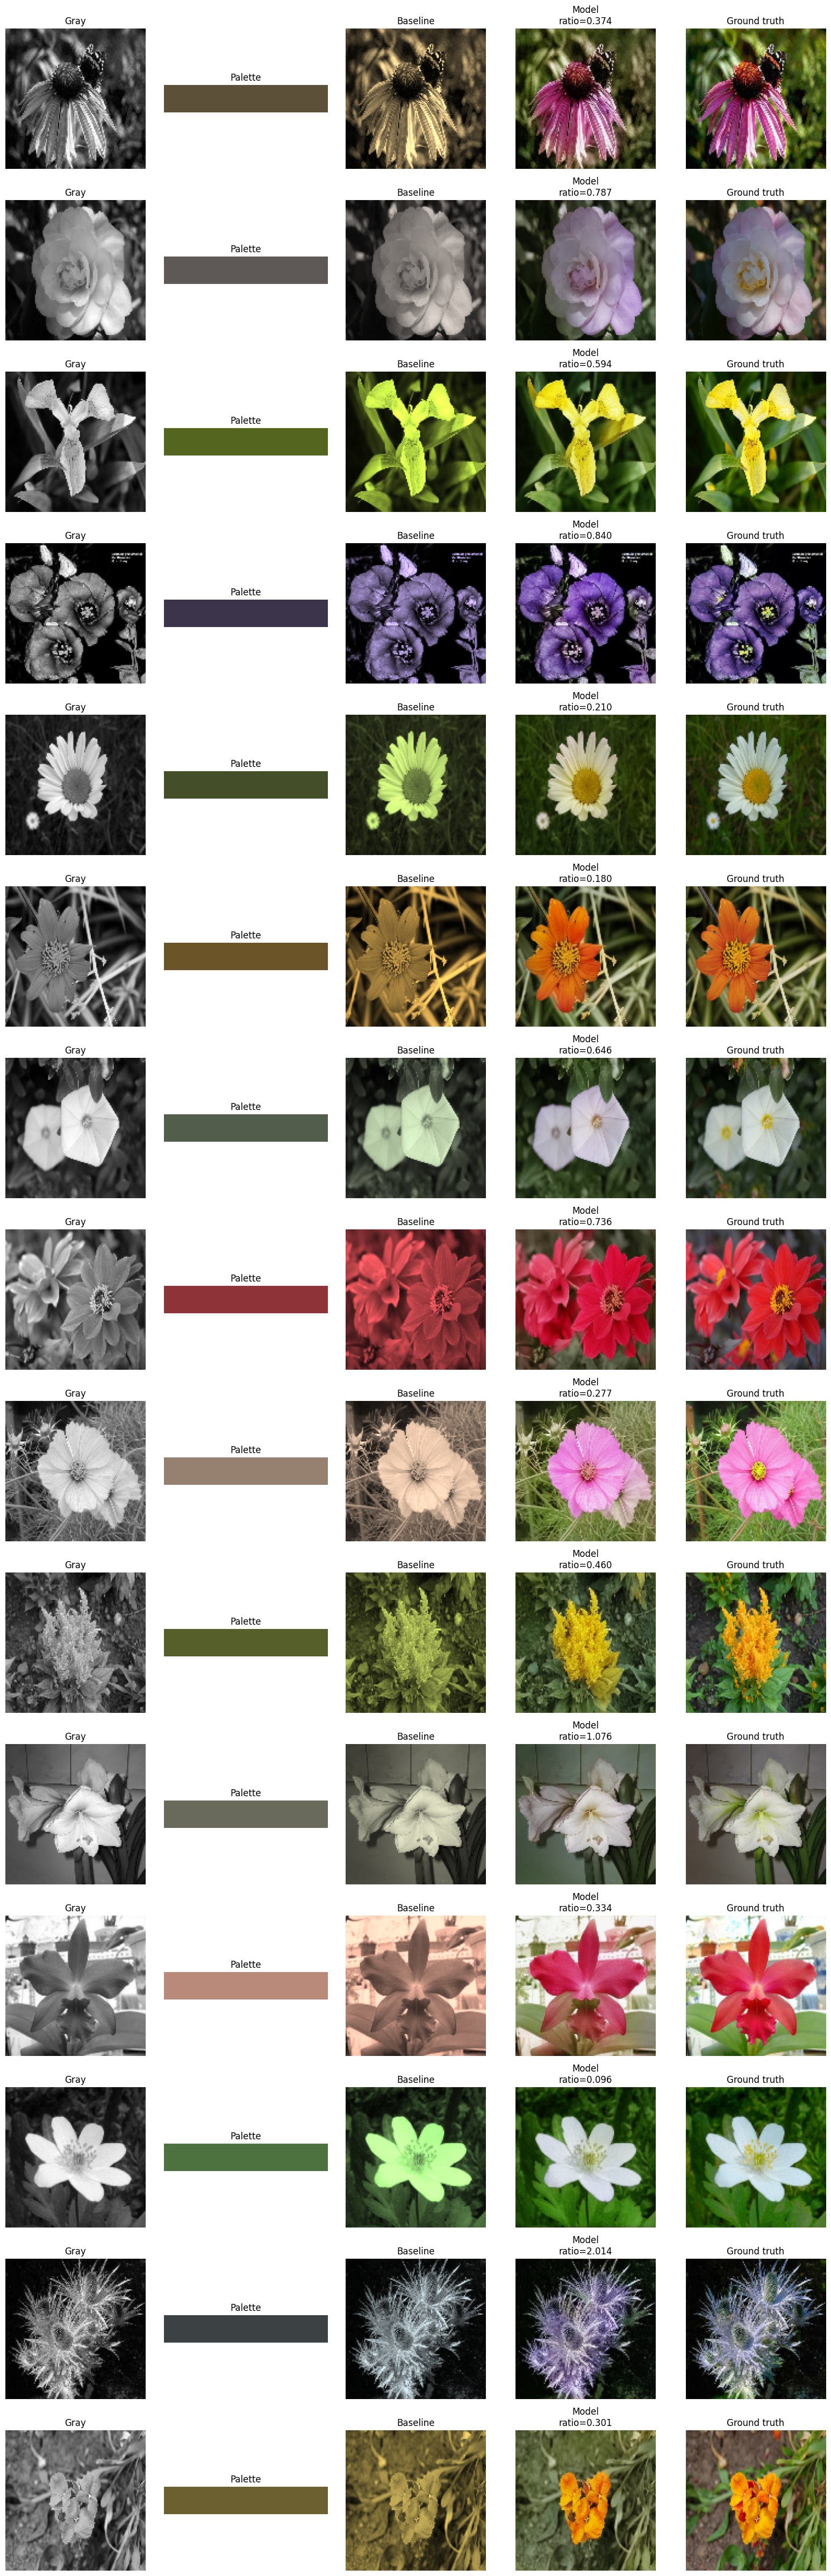

In [42]:
loaded_model = build_colorizer(img_size=IMG_SIZE, widths=(32,64,128,256), bottleneck=256)
loaded_model.load_weights('colorizer_model_2.weights.h5')
print("Model weights loaded.")
show_test_examples(loaded_model, test_gen, n=15)


## Mean and Std of the ratio of generated result over baseline

In [72]:
results = wrapper.evaluate(test_ds, return_dict=True)
print(f"Test mean_ratio: {results['ratio']:.4f} | std_ratio: {results['ratio_std']:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0479 - mse: 0.0048 - ratio: 0.5885 - ratio_std: 0.3428
Test mean_ratio: 0.6063 | std_ratio: 0.3617


**Results:**
**Best MSE Epoch:** 32

**Generated Image MSE:**


*   Train: 0.004
*   Validation: 0.0048
*   Test: 0.0048


**GeneratedImageMSE / BaselineMSE ratio mean:**


*   Train: 0.5619
*   Validation: 0.5974
*   Test: 0.6063

**GeneratedImageMSE / BaselineMSE ratio std:**

*   Train: 0.4268
*   Validation: 0.3563
*   Test: 0.3617


